# Exercício de programação 3 - Cálculo Numérico

## Modelagem de um Sistema de Resfriamento de Chips

### Gabriel Souza Lima - 11820106
### Lucas Pereira da Fonseca - 11808126

### Bibliotecas

In [1]:
#importando as bibliotecas
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns

#definindo o estilo dos gráficos
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=15)    # legend fontsize
plt.rc('font', size=15)          # controls default text sizes

### Funções

In [2]:
def geraVetor(nos_chip,L):
    h = L/(nos_chip+1)
    x_vetor = np.array([i*h for i in range(nos_chip+2)])
    return h, x_vetor

def geraPhi(x, i, h, x_vetor):
    if x_vetor[i-1]<=x and x<=x_vetor[i]: #verificando se x está no intervalo [xi-1,xi]
        phi_i = (x-x_vetor[i-1])/h
    elif x_vetor[i]<=x and x<=x_vetor[i+1]: #verificando se x está no intervalo [xi,xi+1]
        phi_i = (x_vetor[i+1]-x)/h
    else: #se não estiver nos intervalos anteriores, a função é nula
        phi_i = 0
    return  phi_i

def montaVetores(nos_chip, nos_integral, k, q, f, h, x_vetor):
    
    a = np.zeros(nos_chip)
    b = np.zeros(nos_chip)
    c = np.zeros(nos_chip)
    d = np.zeros(nos_chip)
    
    #montando as funções que serão usadas nas integrais
    for i in range(1,nos_chip+1):
        #montando a função de <phi_i, phi_i>l
        phi_i_phi_i = lambda x: k(x)/(h**2) + q(x)*geraPhi(x, i, h, x_vetor)**2 
        
        #montando a função de <phi_i, phi_j>l |j-1|=1
        phi_i_phi_j = lambda x: -1*k(x)/(h**2) + q(x)*geraPhi(x, i, h, x_vetor)*geraPhi(x, i+1, h, x_vetor) 
        
        #montando a função de <f, phi_i>
        f_phi_i_0 = lambda x: f(x)*(x-x_vetor[i-1])/h
        f_phi_i_1 = lambda x: f(x)*(x_vetor[i+1]-x)/h
        #criando vetores a,b,c
        
        #não calculamos a para i=n, pois usamos o intervalo inferior x_vetor[i+1] e o superior x_vetor[i+2]
        if i!=nos_chip: 
            c[i-1] = calcula_integral(nos_integral,x_vetor[i],x_vetor[i+1],phi_i_phi_j)
        #a condição anterior não é usada para b e d, pois usamos o intervalo inferior x_vetor[i-1] e o superior x_vetor[i+1]
        b[i-1] = calcula_integral(nos_integral,x_vetor[i-1],x_vetor[i+1],phi_i_phi_i)
        d[i-1] = calcula_integral(nos_integral,x_vetor[i-1],x_vetor[i],f_phi_i_0)+calcula_integral(nos_integral,x_vetor[i],x_vetor[i+1],f_phi_i_1)
    
    #o vetor c é simétrico ao a, com exceção do primeiro termo, nulo em a, e do último termo, nulo em c
    #podemos otimizar o tempo calculando apenas o c e atribuindo-o ao a, com exceção dos extremos
    a[1:] = c[:-1]
    return a,b,c,d

def encontraAlpha(nos_chip, nos_integral, k, q, f, h, x_vetor):
    a, b, c, d = montaVetores(nos_chip, nos_integral, k, q, f, h, x_vetor) #gerando os vetores
    alpha = resolveSlTridiagonal(a,b,c,d) #resolvendo o sistema tridiagonal
    return alpha

def calculaSolucao(nos_chip, nos_integral, k, q, f, a, b, L):
    #gerando o espaçamento e os nós
    h, x_vetor = geraVetor(nos_chip,L)
    #pontos em que serão calculados a temperatura
    x = np.arange(0,L,L/1000)
    #solução do sistema tridiagonal
    alpha = encontraAlpha(nos_chip, nos_integral, k, q, f, h, x_vetor)
    #lista com valores encontrados
    solucao = []
    for j in range(len(x)): #percorrer x_vetor  
        xj = x[j]
        v = 0
        for i in range(1,nos_chip+1): #percorrer phi
            v += alpha[i-1]*geraPhi(xj, i, h, x_vetor)
        #caso as condições de fronteira não sejam homogêneas
        if a != 0 or b != 0:
            u = v + a + (b - a)*xj/L
        else:
            u = v
        #adiciona o valor encontrado na lista de solução
        solucao.append(u)

    return solucao    

def calculaErroMaximo(nos_chip, nos_integral, exemplo):
    #condições iniciais
    L = 1
    a = b = 0
    #gerando pontos para calcular a solução
    x = np.arange(0,L,L/1000)
    if exemplo == 1:
        k = lambda x: 1
        q = lambda x: 0
        f = lambda x: 12*x*(1-x)-2
        #calculando os valores reais da temperatura
        u = x ** 2 * (1-x)**2 
    elif exemplo == 2:
        k = lambda x: (math.e)**x
        q = lambda x: 0
        f = lambda x: 1 + (math.e)**(x)
        #calculando os valores reais da temperatura
        u = (x-1)*(-1+(math.e)**(-x))
    #temperaturas encontradas pelo método
    u_ = calculaSolucao(nos_chip, nos_integral, k, q, f, a, b, L) 
    #calculando o erro máximo
    erro_max = np.max(np.abs(u_ - u)) 
    return erro_max

def plotaErros(exemplo):
    nos_chip = np.arange(10,100,10)
    nos_integral = 6
    lista_erros = []
    lista_h = []
    for nos in nos_chip:
        h = geraVetor(nos,1)[0]
        erro_max = calculaErroMaximo(nos, nos_integral, exemplo)
        if exemplo==1:
            lista_h.append(1/4 * h**2)
        elif exemplo==2:
            lista_h.append(3/8 * h**2)
        lista_erros.append(erro_max)

    plt.figure(figsize=(10,5.33), tight_layout=True)
    plt.plot(nos_chip, lista_erros ,linewidth=2)
    plt.plot(nos_chip, lista_h ,linewidth=2)
    plt.xlabel('$n (nós)$') 
    plt.title('Erro vs nós') 
    if exemplo==1:
        plt.legend(labels = ['$1/4 h^2$','erro']) 
    elif exemplo==2:
        plt.legend(labels = ['$3/8 h^2$','erro']) 
    plt.show()
    
def plotaExemplo(nos_chip,nos_integral,exemplo):
    n = nos_chip
    #condições iniciais
    L = 1
    a = b = 0  
    #gerando pontos para calcular a solução
    x = np.arange(0,L,L/1000)
    if exemplo == 1:
        k = lambda x: 1
        q = lambda x: 0
        f = lambda x: 12*x*(1-x)-2
        #calculando os valores reais da temperatura
        u = x ** 2 * (1-x)**2 
    elif exemplo == 2:
        k = lambda x: (math.e)**x
        q = lambda x: 0
        f = lambda x: 1 + (math.e)**(x)
        #calculando os valores reais da temperatura
        u = (x-1)*(-1+(math.e)**(-x))
    #temperaturas encontradas pelo método
    u_ = calculaSolucao(nos_chip, nos_integral, k, q, f, a, b, L) 
    #gerando o gráfico
    plt.figure(figsize=(10,5.33),tight_layout=True)
    plt.plot(x, u_ ,linewidth=2)
    plt.plot(x,u,linewidth=2)
    plt.xlabel('$x$') 
    plt.ylabel('$Temperatura$')
    plt.title(f'Temperatura do chip com {nos_chip} nós no exemplo {exemplo}') 
    plt.legend(labels = ['$ \overline{u}_{n}(x) $','$u(x)$']) 
    plt.show()
    
def plotaSolucao(nos_chip,nos_integral,k,q,f,a,b,L):
    #gerando pontos para calcular a solução
    x = np.arange(0,L,L/1000)
    #solução aproximada pelo método
    u_ = calculaSolucao(nos_chip, nos_integral, k, q, f, a, b, L)
    #gerando o gráfico
    plt.figure(figsize=(10,5.33),tight_layout=True)
    plt.plot(x, u_ ,linewidth=2)
    plt.xlabel('$x$') 
    plt.ylabel('$Temperatura$')
    plt.title(f'Temperatura do chip com {nos_chip} nós') 
    plt.legend(labels = ['$ \overline{u}_{n}(x)$']) 
    plt.show()
    
def cria_nos_pesos(n):
    """Cria os nós e os pesos que serão utilizados para calcular as integrais
    Args: 
        n:  quantidade de pontos
    Return:
        x: nós 
        w: pesos"""
    if n == 6:
        x = np.array([-0.2386191860831969086305017,-0.6612093864662645136613996,-0.9324695142031520278123016,
                        0.2386191860831969086305017,0.6612093864662645136613996,0.9324695142031520278123016])
        w = np.array([0.4679139345726910473898703,0.3607615730481386075698335,0.1713244923791703450402961,
                        0.4679139345726910473898703,0.3607615730481386075698335,0.1713244923791703450402961])
    elif n == 8:
        x = np.array([-0.1834346424956498049394761,-0.5255324099163289858177390,-0.7966664774136267395915539,-0.9602898564975362316835609,
                        0.1834346424956498049394761,0.5255324099163289858177390,0.7966664774136267395915539,0.9602898564975362316835609])
        w = np.array([0.3626837833783619829651504,0.3137066458778872873379622,0.2223810344533744705443560,0.1012285362903762591525314,
                        0.3626837833783619829651504,0.3137066458778872873379622,0.2223810344533744705443560,0.1012285362903762591525314])
    elif n == 10:
        x = np.array([-0.1488743389816312108848260,-0.4333953941292471907992659,-0.6794095682990244062343274,-0.8650633666889845107320967,-0.9739065285171717200779640,
                         0.1488743389816312108848260,0.4333953941292471907992659,0.6794095682990244062343274,0.8650633666889845107320967,0.9739065285171717200779640])
        w = np.array([0.2955242247147528701738930,0.2692667193099963550912269,0.2190863625159820439955349,0.1494513491505805931457763,0.0666713443086881375935688,
                         0.2955242247147528701738930,0.2692667193099963550912269,0.2190863625159820439955349,0.1494513491505805931457763,0.0666713443086881375935688])
    return x, w


def calcula_integral(n,a,b,f):
    """Calcula a integral de uma função com limites inferior e superior constantes
    Args: 
        a: limite inferior
        b: limite superior
        f: função a ser integrada
        n: número de pontos"""
    nos, w = cria_nos_pesos(n) #gerando os nós e os pesos
    nos_t = (nos*(b-a)+a+b)/2 #transportando os nós para o intervalo [a,b]
    w_t = w*(b-a)/2 #transportando os pesos para o intervalo [a,b]
    f_vec = np.vectorize(f)
    F = f_vec(nos_t) #calculando f(x) para os valores transportados
    I = F @ w_t  #calculando a integral
    return I

def decompoeTridiagonalLU(a,b,c):
    """Faz a decomposição em LU de uma matriz A nxn tridiagonal, com coeficientes a, b, c.
    Args: 
        a, b, c: diagonais não nulas da matriz tridiagonal A
    Return:      
        l: multiplicadores da matriz L
        u: diagonal principal de U
    """
    n = len(a)
    u = np.zeros(n)
    l = np.zeros(n)
    u[0] = b[0]
    for i in range(1,n,1):
        l[i] = a[i]/u[i-1]
        u[i] = b[i]-l[i]*c[i-1]
    return l, u

def resolveSlTridiagonal(a,b,c,d):
    """Resolve um sistema linear tridiagonal
    Args:
        a, b, c: diagonais não nulas da matriz tridiagonal A
        d: vetor tal que Ax = d
    Return:
        x: solução do sistema linear
    """
    #gerando os vetores que representam L e U
    l, u = decompoeTridiagonalLU(a,b,c) 
    
    n = len(a)
    y = np.zeros(n)
    x = np.zeros(n)
    
    #Ly = d
    y[0] = d[0]
    for i in range(1,n,1):
        y[i] = d[i] - l[i]*y[i-1]
        
    #Ux = y
    x[n-1] = y[n-1]/u[n-1]
    for i in range(n-2,-1,-1):
        x[i] = (y[i] - c[i]*x[i+1])/u[i]
        
    return x

### Exercício 1
Escolha os valores para os nós usados no método dos elementos finitos, os nós para calcular a integral, que deve ser 6, 8 ou 10 e o exemplo que será usado: 1 refere-se ao exemplo inicial da seção 4.2 e 2 refere-se ao novo exemplo proposto.

Rode a célula.

O maior erro cometido para o exemplo 1 com 63 nós foi: 5.814417157811694e-05 



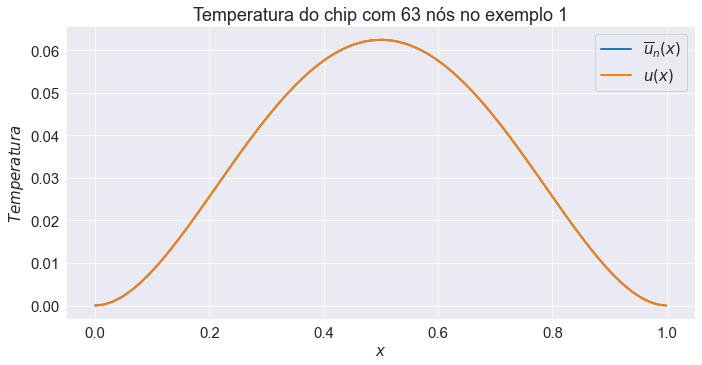

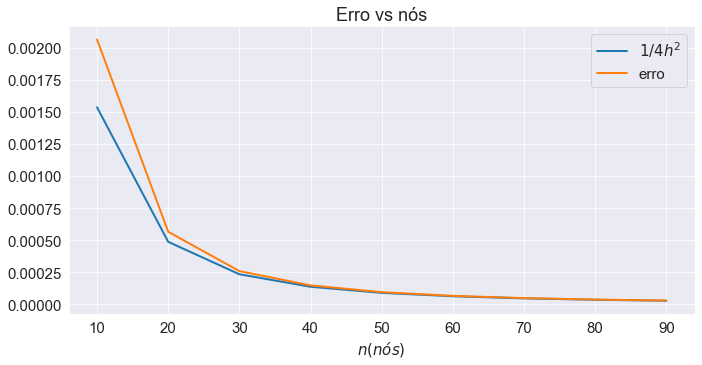

In [3]:
#escolha o exemplo 1(da seção 4.2) ou o exemplo 2(complemento da seção 4.2)
exemplo = 1
#escolha o número de nós no chip
nos_chip = 63
#escolha 6, 8 ou 10 para o cálculo da integral
nos_integral = 10

erro_max = calculaErroMaximo(nos_chip, nos_integral, exemplo)
print(f"O maior erro cometido para o exemplo {exemplo} com {nos_chip} nós foi: {erro_max} \n")

plotaExemplo(nos_chip,nos_integral,exemplo)
plotaErros(exemplo)

### Exercício 2

Para o exercício 2, pode-se escolher o número de nós no chip, o número de nós na integral, o tamanho do chip, o calor fornecido, as condições de fronteira, a condutividade $k(x)$ e a forçante $f(x)$. Os dados iniciais são os mesmo do enunciado.

#### Aquecimento

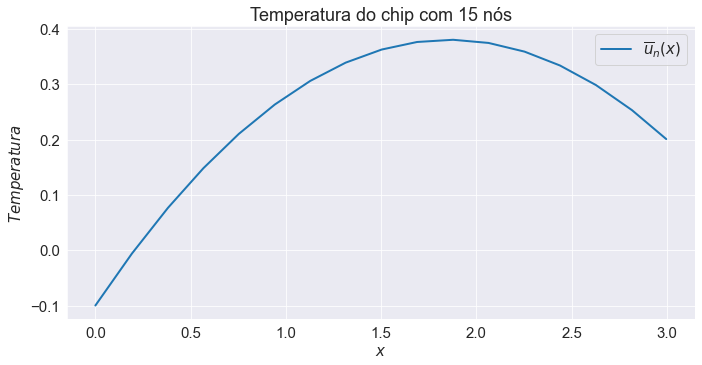

In [4]:
#escolha o número de nós no chip
nos_chip = 15
#escolha 6, 8 ou 10 para o cálculo da integral
nos_integral = 8

#parâmetros e condições de fronteira
L = 3
a = -0.1
b = 0.2
sigma = 100
Q = 1

k = lambda x: 3.6
q = lambda x: 0
f = lambda x: Q*math.e**((-(x-L/2)**2)/sigma**2)

plotaSolucao(nos_chip,nos_integral,k,q,f,a,b,L)

#### Resfriamento

Pode-se escolher o número de nós no chip, o número de nós na integral, o tamanho do chip, as condições de fronteira, o calor retirado, a condutividade $k(x)$ e a forçante $f(x)$. Os dados iniciais são os mesmo do enunciado.

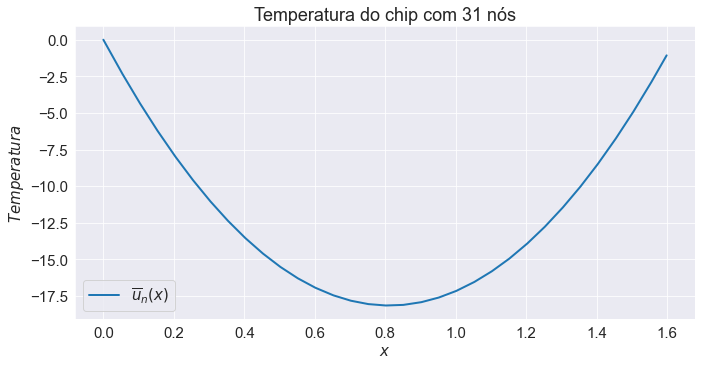

In [5]:
#escolha o número de nós no chip
nos_chip = 31
#escolha 6, 8 ou 10 para o cálculo da integral
nos_integral = 10

#parâmetros e condições de fronteira
L = 1.6
a = 0
b = -1
theta = 10
Q_ = -100

k = lambda x: 3.6
q = lambda x: 0
f = lambda x: Q_*(math.e**(-(x/theta)**2)+math.e**(-(x-L)**2 / theta**2))

plotaSolucao(nos_chip,nos_integral,k,q,f,a,b,L)

#### Aquecimento e Resfriamento

Pode-se escolher o número de nós no chip, o número de nós na integral, o tamanho do chip, as condições de fronteira, o calor fornecido, o calor retirado, a condutividade $k(x)$ e a forçante $f(x)$. Os dados são a junção dos dois exemplos anteriores.

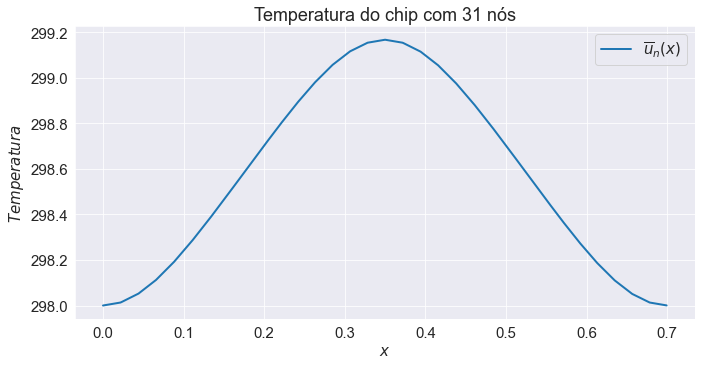

In [13]:
#escolha o número de nós no chip
nos_chip = 31
#escolha 6, 8 ou 10 para o cálculo da integral
nos_integral = 10

#parâmetros e condições de fronteira
L = 0.7
a = 298
b = 298
theta = 0.1
sigma = 0.1
Q = 200
Q_ = -200

k = lambda x: 3.6
q = lambda x: 0
f = lambda x: Q_*(math.e**(-(x/theta)**2)+math.e**(-(x-L)**2 / theta**2)) + Q*math.e**((-(x-L/2)**2)/sigma**2)

plotaSolucao(nos_chip,nos_integral,k,q,f,a,b,L)

### Exercício 3

Neste exemplo, pode-se também escolher qual será o valor da condutividade térmica no centro do chip ($k1$) e nos extremos do chip ($k2$). 

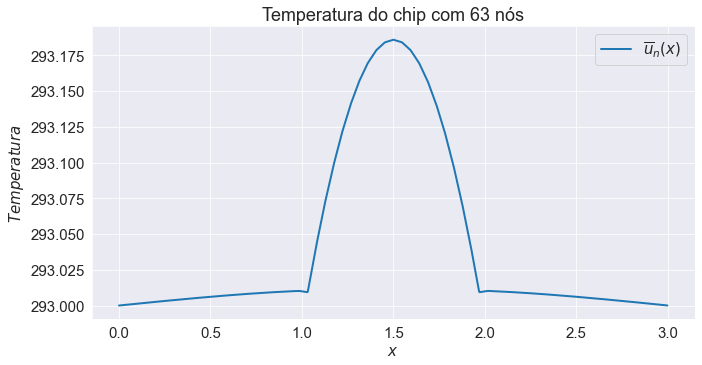

In [26]:
#escolha o número de nós no chip
nos_chip = 63
#escolha 6, 8 ou 10 para o cálculo da integral
nos_integral = 10

#parâmetros e condições de fronteira
L = 3

a = 293
b = 293
d = 0.5

#escolha os valores da condutividade térmica
k1 = 6
k2 = 500
sigma = 1

k = lambda x: k1 if (x>(L/2-d) and x<(L/2+d)) else k2
    
q = lambda x: 0
f = lambda x: 10*math.e**((-(x-L/2)**2)/sigma**2)

plotaSolucao(nos_chip,nos_integral,k,q,f,a,b,L)